# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.



In [1]:
# Are we using a GPU?
!nvidia-smi

Wed Aug 10 20:30:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and Becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-08-10 20:30:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   276MB/s    in 0.6s    

2022-08-10 20:30:52 (276 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

## Creating data loaders (preparing the data) 

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE, 
                                                          class_mode = 'categorical')

print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


##  Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality we can add to our models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback


In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

> 🔑**Note:** We can customize the directory where our TensorBoard logs (model training metrics) get saved to whatever we like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [7]:
# Import dependencies
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras import layers 

In [8]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Seuquential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = 'feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE + (3,)) # freeze the already learned patterns

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])

  return model



### Creating and Testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [10]:
# Compile our Resnet Model
resnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [11]:
# Check the summary of our Resnet Model
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# Let's fit our ResNet model to the data (10 percent of classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                           experiment_name = 'resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220810-203108
Epoch 1/5
24/24 [==============================] - 32s 754ms/step - loss: 2.0488 - accuracy: 0.2960 - val_loss: 1.2505 - val_accuracy: 0.6160
Epoch 2/5
24/24 [==============================] - 16s 678ms/step - loss: 0.9527 - accuracy: 0.7027 - val_loss: 0.8659 - val_accuracy: 0.7320
Epoch 3/5
24/24 [==============================] - 16s 703ms/step - loss: 0.6515 - accuracy: 0.8147 - val_loss: 0.7517 - val_accuracy: 0.7628
Epoch 4/5
24/24 [==============================] - 16s 667ms/step - loss: 0.4906 - accuracy: 0.8760 - val_loss: 0.7129 - val_accuracy: 0.7668
Epoch 5/5
24/24 [==============================] - 15s 663ms/step - loss: 0.3856 - accuracy: 0.9107 - val_loss: 0.6787 - val_accuracy: 0.7860


Wow! Looks like our transfer learning feature extractor model out performed all of the previosu models we built by hand. (substantially) and in a quicker training time. More importantly with only 10% of the training examples.

In [13]:
# Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics

  Args:
    history: TensorFlow History object.
  
  Returns: 
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = 'Training loss', color = 'orange' )
  plt.plot(epochs, val_loss, label = 'Validation loss', color = 'blue')
  plt.title('Training Loss vs Validation Loss')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label = 'Training accuracy', color = 'green')
  plt.plot(epochs, val_accuracy, label = 'Validation accuracy', color = 'purple')
  plt.title('Training Accuracy vs Validation Accuracy')
  plt.xlabel('epochs')
  plt.legend();

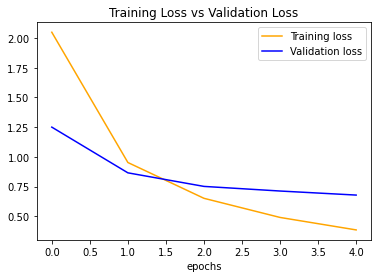

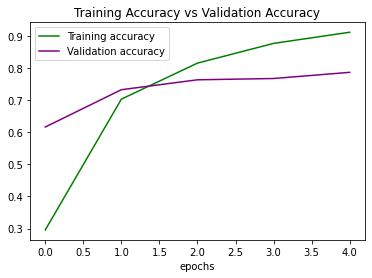

In [14]:
# Plot loss curves
plot_loss_curves(resnet_history)

### Creating and Testing EfficientNetB0 TensorFlow Hub Feature Extraction Model

In [15]:
# Create EfficientNetB0 Feature Extraction Model
efficientnet_model = create_model(efficientnet_url,
                                  num_classes = train_data_10_percent.num_classes)

# Compile our EfficientNetB0 Model
efficientnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

# Fit EfficientNetB0 Model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                               epochs = 5,
                                               steps_per_epoch = len(train_data_10_percent),
                                               validation_data = test_data,
                                               validation_steps = len(test_data),
                                               callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                                        experiment_name = 'efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220810-203257
Epoch 1/5
24/24 [==============================] - 26s 714ms/step - loss: 1.8381 - accuracy: 0.4533 - val_loss: 1.2787 - val_accuracy: 0.7284
Epoch 2/5
24/24 [==============================] - 15s 636ms/step - loss: 1.0452 - accuracy: 0.7667 - val_loss: 0.8588 - val_accuracy: 0.8156
Epoch 3/5
24/24 [==============================] - 15s 640ms/step - loss: 0.7455 - accuracy: 0.8347 - val_loss: 0.6959 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 15s 646ms/step - loss: 0.6013 - accuracy: 0.8693 - val_loss: 0.6077 - val_accuracy: 0.8488
Epoch 5/5
24/24 [==============================] - 15s 646ms/step - loss: 0.5093 - accuracy: 0.8813 - val_loss: 0.5553 - val_accuracy: 0.8532


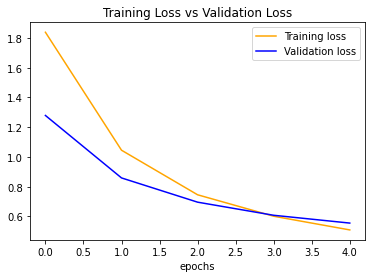

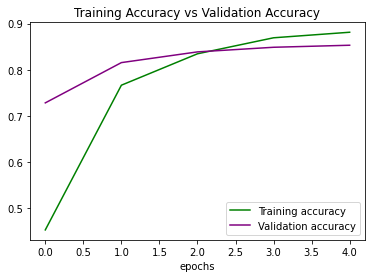

In [16]:
# Plot loss curves of our efficientnetb0 model
plot_loss_curves(efficientnet_history)

In [17]:
# Check the summary of our efficientnetb0 model
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [18]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning 

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of our own)
* **"Feature Extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for our own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑**Note:** When we upload things to TensorBoard.dev, our experiments are public. So if we're running private experiments (things we don't want others to see) do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/TJc9pqW1SAuRjQ23S478CQ/

In [20]:
# Check out what TensorBoard experiments we have
!tensorboard dev list

https://tensorboard.dev/experiment/TJc9pqW1SAuRjQ23S478CQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   TJc9pqW1SAuRjQ23S478CQ
	Created              2022-08-10 20:41:25 (2 minutes ago)
	Updated              2022-08-10 20:41:30 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918538
https://tensorboard.dev/experiment/Q3ViV8w2SQOMYm0TgXppeg/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   Q3ViV8w2SQOMYm0TgXppeg
	Created              2022-08-10 20:26:02 (18 minutes ago)
	Updated              2022-08-10 20:26:13 (18 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              150
	Tensor 

In [21]:
# Delete an experiment 
!tensorboard dev delete --experiment_id Q3ViV8w2SQOMYm0TgXppeg

Deleted experiment Q3ViV8w2SQOMYm0TgXppeg.


In [22]:
# Confirm the deletion by re-checking what experiments we have left
!tensorboard dev list

https://tensorboard.dev/experiment/TJc9pqW1SAuRjQ23S478CQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   TJc9pqW1SAuRjQ23S478CQ
	Created              2022-08-10 20:41:25 (4 minutes ago)
	Updated              2022-08-10 20:41:30 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918538
Total: 1 experiment(s)
